Task 1.
The first source I used for this was: https://www.easy-tensorflow.com/tf-tutorials/neural-networks/two-layer-neural-network?view=article&id=124:two-layer-neural-network
This one helped to explain the concepts and get me started but the tutorial itself is for tensorflow 1 so I was not able to use it beyond that.

The second I used was this: https://www.tensorflow.org/tutorials/load_data/images
This one was helpful in setting up all the data that I am using all the way up to training the model, it was my main source. It is an official tensorflow tutorial and does a good job explaining all the steps so it was very useful.

I also made some use of the page: https://www.tensorflow.org/tutorials/images/classification#predict_on_new_data 
This is essentially a more in depth version of the previous source that I referenced a little to gain some more information on training the model.

I also made use of a couple of the pages on tensorflow explaining the parts in further depth such as: https://www.tensorflow.org/api_docs/python/tf/data/Dataset to figure out how to parse some of the data.

Task 2.
I am solving the problem of being able to recognize different types of locations based on pictures.
I used the data from here: https://www.kaggle.com/puneet6060/intel-image-classification.
This data is from a competition Intel did at some point in the past and had already been trained on a model before, so the train-test-dev split had already been preformed on it. I decided to use only the pictures in the train folder instead of manually recombining everything becuase it is large enough on its own, and in the intrest of performing this part myself with the option of randomization. The images are also converted from the [0, 255] color scale to a [0, 1] scale for better performance.

First the imports.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import PIL
import PIL.Image
import pathlib

Load the data. Also a look at what kind of images we are working with.

2191


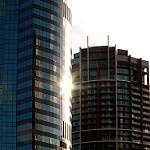

In [2]:
batch_size = 10
img_h = img_w = 150

data_dir = pathlib.Path('./seg_train/seg_train')

buildings = list(data_dir.glob('buildings/*'))
print(len(buildings))
PIL.Image.open(str(buildings[0]))

Preform tthe train-dev-test-split. tf.keras.preprocessing.image_dataset_from_directory() did not support having all three splits, so I improvised by spliting the validation split into two manually.

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.50,
  subset="training",
  seed=123,
  image_size=(img_h, img_w),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.50,
  subset="validation",
  seed=123,
  image_size=(img_h, img_w),
  batch_size=batch_size)

test_ds = val_ds.take(100)
dev_ds = val_ds.skip(100)

Found 14034 files belonging to 6 classes.
Using 7017 files for training.


2021-09-30 01:52:28.261611: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 14034 files belonging to 6 classes.
Using 7017 files for validation.


Standardize RGB channel to be [0,1] instead of [0,255], and configure loading data for performance

In [4]:
class_names = val_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
dev_ds = dev_ds.cache().prefetch(buffer_size=AUTOTUNE)

Implement the model with forward propagation.
The activation funtion is relu and the hyper paremeters are as follows:

epochs = 10: I found litte improvement with more epochs after this

batch_size = 10: A small batch size, I found this works well with my data

learning_rate = 0.05: With some experimentation I found this to be a good value for the learning rat on SGD, too high or too low led to much worse results

In [5]:
num_classes = 6

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer = tf.keras.optimizers.SGD(learning_rate=0.05, decay=0.1, momentum=0.1, nesterov=False),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.fit(
  train_ds,
  validation_data=dev_ds,
  batch_size = 10,
  epochs=10
)

Epoch 1/10
  1/702 [..............................] - ETA: 5:00 - loss: 1.9518 - accuracy: 0.0000e+00

2021-09-30 01:52:29.088514: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


702/702 [==============================] - 82s 116ms/step - loss: 1.2771 - accuracy: 0.5100 - val_loss: 1.1231 - val_accuracy: 0.5503
Epoch 2/10
702/702 [==============================] - 78s 111ms/step - loss: 1.0636 - accuracy: 0.5990 - val_loss: 1.0622 - val_accuracy: 0.5795
Epoch 3/10
702/702 [==============================] - 78s 111ms/step - loss: 1.0230 - accuracy: 0.6166 - val_loss: 1.0352 - val_accuracy: 0.5932
Epoch 4/10
702/702 [==============================] - 76s 108ms/step - loss: 1.0002 - accuracy: 0.6278 - val_loss: 1.0183 - val_accuracy: 0.6023
Epoch 5/10
702/702 [==============================] - 76s 109ms/step - loss: 0.9848 - accuracy: 0.6339 - val_loss: 1.0067 - val_accuracy: 0.6101
Epoch 6/10
702/702 [==============================] - 80s 114ms/step - loss: 0.9730 - accuracy: 0.6396 - val_loss: 0.9978 - val_accuracy: 0.6153
Epoch 7/10
702/702 [==============================] - 78s 111ms/step - loss: 0.9638 - accuracy: 0.6420 - val_loss: 0.9910 - val_accuracy: 0.6

The final cost is: 0.9445

Now test it out using the test set. It displays a few of its guesses for clarity.

In [6]:
predictions = model.predict(test_ds)
score = tf.nn.softmax(predictions[0])
    
labels = list(map(lambda x: x[1], test_ds))
lis = []
#getting true labels
for i in range(0, 10):
    for z in range(0, 10):
        lis.append(tf.get_static_value(list(labels[i])[z]))

average = 0
correct = 0
for i in range(0, 100):
  score = tf.nn.softmax(predictions[i])
  average += 100 * np.max(score)
  if np.argmax(score) == lis[i]:
    correct += 1
  if  i % 10 == 0:
      print(
        "This image is most likely a {} with a {:.2f} confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

print("Predicted confidence average:")
print(str(average / 100) + "%")
print("Percent of guesses that are correct:")
print(str(correct) + "%")

This image is most likely a glacier with a 39.89 confidence.
This image is most likely a mountain with a 53.20 confidence.
This image is most likely a street with a 68.84 confidence.
This image is most likely a glacier with a 45.95 confidence.
This image is most likely a mountain with a 56.86 confidence.
This image is most likely a glacier with a 58.09 confidence.
This image is most likely a mountain with a 41.48 confidence.
This image is most likely a sea with a 38.14 confidence.
This image is most likely a sea with a 36.02 confidence.
This image is most likely a street with a 51.54 confidence.
Predicted confidence average:
59.02533820271492%
Percent of guesses that are correct:
65%


The model guessed correct on the test set about as much as it was expected to. 65% is not great but it is pretty much exactly what the model accuracy was predicted to be. And given that there are 6 possible classifications and the model predicts correctly 65% of the time, it is definitly doing much better than random guessing.

Part 3.
I selected my hyper parameters in part 2 mostly through trying different values and seeing what worked best. If I felt that the model was over or under fitting I would change parameters around to try and make it better. Overall I kept a lot of the values at their default as I didn't find changing them to benefit the model much, but I found the learning rate and batch size to be fairly important so I spent a fair amount of time tuning those values.

I used the model that I did after testing what worked and what did not. Initially my accuracy was fairly low and I found that adding more epochs and changing the learning rate helped. Although the benefit of additional epochs started to severly diminish after around 5, so I stopped at 10 which might still be a little much. I also found that using an optimizer was a good idea because it improved my results overall. Initially I used the Adam optimizer, but I found that SGD worked a little bit better.

There was no need for regularization though, my data does not have a lot of points in it that didn't really fit. The only two catagories of pictures that are somewhat close to one another are streets and buildings, but even in these catagories there were not enough borderline pictures to throw off the model so long as it was not majorly overfitting.